# More Sophisticated Parameters

This example assumes that you are familiar with the sequencing process. If you need a refresher on this, have a look at [The Sequencing Process: Obtaining Pulse Instances From Pulse Templates](04Sequencing.ipynb) first.

*Attention/Broken: During the creation of this example some implementation errors were found in the qctoolkit. Due to time constraints, these were not fixed immediately, leaving this example to be slightly flawed. However, in order to demonstrate the underlying principles, this example is published in its current form. Annotations like this mark where the current behavior of the qctoolit diverges from the intended one.*

So far we have only considered constant parameter values. Now assume that we need to derive the value for a parameter based on some measurements we've made during the execution of previous parts of a composite pulse. For example, let the pulse we want to execute be constructed as follows:

<IPython.core.display.Javascript object>


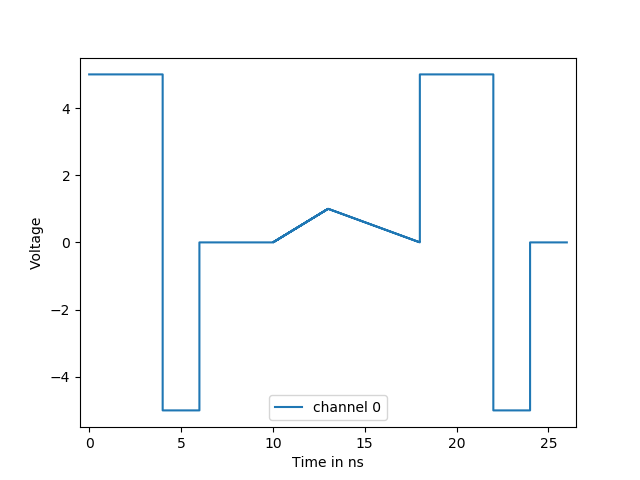

<IPython.core.display.Javascript object>


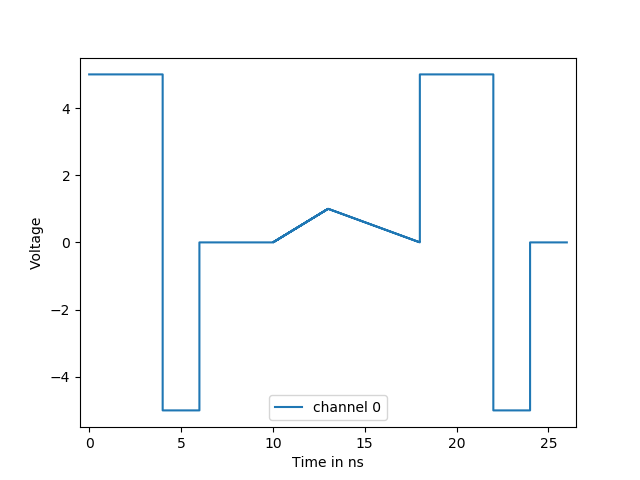

In [19]:
%matplotlib notebook
from qctoolkit.pulses import TablePT, SequencePT
from qctoolkit.pulses.plotting import plot

init_template = TablePT(entries={0: [(2, 5),
                                     (4, -5),
                                     (6, 0),
                                     (8, 0)]})

dependent_template = TablePT(entries={0: [(2, 0),
                                          (5, 'v', 'linear'),
                                          (10, 0, 'linear')]},
                             measurements=[('A', 0, 2),
                                           ('B', 4, 0)])

sequence_template = SequencePT((init_template, {}),
                               (dependent_template, {'v': 'v'}),
                               (init_template, {}))

plot(sequence_template, {'v': 1}, sample_rate=100)

Now we want to let the value of parameter `v` depend somehow on the measurement we make between time 8 and 12 (assuming we have a way to obtain measurement data, which is currently not the case (work in progress)). Thus we need to execute the first part of the pulse, then compute the parameter value and execute the remainder. We can do so be encapsulating the computation of the parameter value in a custom subclass of `Parameter`. Assuming, for simplicity, that we have some `measurement_manager` object which we can query whether or not the measurement has been made (`is_measurement_available()`) and what data was obtained (`get_data()`) and that the value of `v` shall simply be twice the measured data, this subclass might look like this:

In [20]:
from qctoolkit.pulses.parameters import Parameter

class MeasurementDependentParameter(Parameter):
    
    def __init__(self, measurement_manager) -> None:
        self.measurement_manager = measurement_manager
    
    @property
    def requires_stop(self) -> bool:
        return not self.measurement_manager.is_measurement_available()
        
    def get_value(self) -> float:
        return 2*(self.measurement_manager.get_data())
    
    def get_serialization_data(self, serializer):
        raise NotImplementedError()
        
    @staticmethod
    def deserialize(serializer):
        raise NotImplementedError()

We overwrite the abstract property `requires_stop` and the abstract method `get_value` of the `Parameter` base class. `requires_stop` is used to indicate to the `Sequencer` whether the `Parameter` object can currently be evaluated or whether the sequencing process has to be interrupted. Our `MeasurementDependentParameter` will return `True` if no measurement data is available (in contrast, the `ConstantParameter` - which internally represents any float value passed in - always returns `False`). The `get_value` method returns the parameter value. It is only called if `requires_stop` is false. In the `MesaurementDependentParameter` class, we assume that the measured data is a single float and that we simple want to multiply it by 2 as the parameter's value. The other two methods, `get_serialization_data` and `deserialize` also must be overwritten since each `Parameter` implements the [`Serializable` interface](03Serialization.ipynb). However, we just raise an exception here since these methods are not relevant in this example.

We would then set up our pulse for execution like as in the following snippet (including a stub implementation of a `MeasurementManager` just for demonstration purposes):

In [21]:
from qctoolkit.pulses import Sequencer

# We define a stub for the measurement manager here only for illustration purposes.
class MeasurementManager:
    def __init__(self, sequencer: Sequencer) -> None:
        self.sequencer = sequencer
        self.is_available = False
        
    def is_measurement_available(self) -> bool:
        return self.is_available
    
    def get_data(self) -> float:
        return 3

sequencer = Sequencer()
measurement_manager = MeasurementManager(sequencer)
parameter = MeasurementDependentParameter(measurement_manager)

sequencer.push(init_template)
sequencer.push(dependent_template, {'v': parameter})
sequencer.push(init_template)

The `MeasurementManager.is_measurement_available` stub will simply return the value to which we have set the `is_available` member variable of the class.

When we invoke `Sequencer.build`, for each template on the sequencing stack it first queries whether or not all parameters can be evaluated. If any of them returns `True` via the `requires_stop` method, the sequencing process will be interrupted.
In our example, `Sequencer` will first proceed through the first two subtemplates of `sequence_template`. When it arrives at `dependent_template`, it will stop:

In [22]:
first_block = sequencer.build()
print([instruction for instruction in first_block])

[<qctoolkit.pulses.instructions.MEASInstruction object at 0x00000231096BD4E0>, <qctoolkit.pulses.instructions.EXECInstruction object at 0x00000231096BD940>, <qctoolkit.pulses.instructions.STOPInstruction object at 0x00000231096BD3C8>]


As you can see in the output above, only two executions instructions are generated, one for each `TablePulseTemplate` instance before the `dependent_template`. Let us now switch the `is_available` variable of the `MeasurementManager` instance to `True`, simulating that we've obtained some measurement result, and invoke the `Sequencer` again:

In [23]:
measurement_manager.is_available = True
second_block = sequencer.build()
print([instruction for instruction in second_block])

[<qctoolkit.pulses.instructions.MEASInstruction object at 0x00000231096BD4E0>, <qctoolkit.pulses.instructions.EXECInstruction object at 0x00000231096BD940>, <qctoolkit.pulses.instructions.MEASInstruction object at 0x000002310914AC50>, <qctoolkit.pulses.instructions.EXECInstruction object at 0x000002310914ABE0>, <qctoolkit.pulses.instructions.MEASInstruction object at 0x000002310914AEF0>, <qctoolkit.pulses.instructions.EXECInstruction object at 0x000002310914A4E0>, <qctoolkit.pulses.instructions.STOPInstruction object at 0x000002310914AB70>]


We have now obtained the complete sequence with one execution instruction for each `TablePulseTemplate`.
*Attention/Broken: Currently this is incorrect behavior: We would want to only get the remainder of the pulse in the second call since we wouldn't want to execute the first part of the pulse again. Needs fixing ([issue 105](https://github.com/qutech/qc-toolkit/issues/105)).*